# 逻辑回归 Logistic Regression

## 原理

- 主要解决分类问题
- 天然的解决二分类问题
- 通过变形可以解决多分类(ovo,ovr)
- 分类用概率衡量指标,数值用r方  
![](https://raw.githubusercontent.com/LinCheungS/PicGo_Image_Storage/master/2020-1/20200423035625.png)

### Sigmod函数

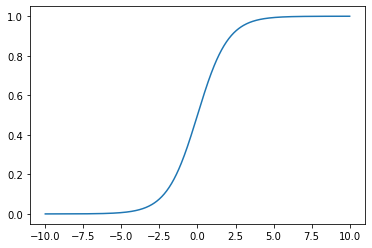

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(t):
    return 1. / (1. + np.exp(-t))

x = np.linspace(-10, 10, 500)
plt.plot(x, sigmoid(x))
plt.show()

值域0-1,定义域为0时,值为0.5  
x>0, y>0.5  
x<0, y<0.5  

### 公式推导

1. sigmod函数嵌套sigmod,使值映射到0-1  
$$\hat p = \sigma ({\theta ^T} \cdot {x_b}) = \frac{1}{{1 + {e^{ - {\theta ^t} \cdot {x_b}}}}}$$  
2. 计算cost,使呈现某种惩罚机制(越偏离,惩罚越大)  
$$\cos t = \left\{ {\begin{array}{*{20}{c}}
{ - \log (\hat p)}\\
{ - \log (1 - \hat p)}
\end{array}} \right.{\rm{  }}\begin{array}{*{20}{c}}
{True = 1}\\
{True = 0}
\end{array}.$$
![](https://raw.githubusercontent.com/LinCheungS/PicGo_Image_Storage/master/2020/20200418230855.jpg)   
3. 确定损失函数
$$J(\theta )=-\frac{1}{m}\sum\limits_{i = 1}^m {{y^i}\log ({{\hat p}^i}) + (1 - {y^i})\log (1 - {{\hat p}^i})}$$
4. 损失函数求导(不存在数学解,只能梯度下降)
$$J(\theta )'=\frac{1}{m} \cdot X_b^T \cdot (\sigma ({X_b}\theta ) - y)$$




### OvO 和 OvR

![](https://raw.githubusercontent.com/LinCheungS/PicGo_Image_Storage/master/2020-1/20200423040410.jpg)
- OvR(One Vs Rest)
  - 对n种类别的样本分类，取一种样本作为一类，剩余看做另一类
  - 这样就形成了n个二分类问题
![](https://raw.githubusercontent.com/LinCheungS/PicGo_Image_Storage/master/2020-1/20200423040430.jpg)
- OvO(One Vs One)
  - 对n种类别的样本分类，采取1对1的策略
  - $C_n^2$，其中n表示训练集中类别的数量
  - 速度慢,效果好
![](https://raw.githubusercontent.com/LinCheungS/PicGo_Image_Storage/master/2020-1/20200423040439.png)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

1.0

In [24]:
# OVR
from sklearn.multiclass import OneVsRestClassifier

ovr = OneVsRestClassifier(log_reg)
ovr.fit(X_train, y_train)
ovr.score(X_test, y_test)

0.9736842105263158

In [25]:
# OVO
from sklearn.multiclass import OneVsOneClassifier

ovo = OneVsOneClassifier(log_reg)
ovo.fit(X_train, y_train)
ovo.score(X_test, y_test)

1.0

### 自我实现

In [2]:
import numpy as np
import numpy as np
from math import sqrt


class LogisticRegression:
    """初始化Logistic Regression模型"""
    def __init__(self):
        self.coef_ = None
        self.intercept_ = None
        self._theta = None

    """sigmod函数"""

    def _sigmoid(self, t):
        return 1. / (1. + np.exp(-t))

    """计算y_true和y_predict之间的准确率"""

    def accuracy_score(self, y_true, y_predict):
        assert len(y_true) == len(y_predict), \
            "the size of y_true must be equal to the size of y_predict"
        return np.sum(y_true == y_predict) / len(y_true)

    """根据训练数据集X_train, y_train, 使用梯度下降法训练Logistic Regression模型"""

    def fit(self, X_train, y_train, eta=0.01, n_iters=1e4):
        assert X_train.shape[0] == y_train.shape[0], \
            "the size of X_train must be equal to the size of y_train"
        """损失函数"""
        def J(theta, X_b, y):
            y_hat = self._sigmoid(X_b.dot(theta))
            try:
                return -np.sum(y * np.log(y_hat) +
                               (1 - y) * np.log(1 - y_hat)) / len(y)
            except:
                return float('inf')

        """损失函数求导"""

        def dJ(theta, X_b, y):
            return X_b.T.dot(self._sigmoid(X_b.dot(theta)) - y) / len(y)

        """梯度下降"""

        def gradient_descent(X_b,
                             y,
                             initial_theta,
                             eta,
                             n_iters=1e4,
                             epsilon=1e-8):
            theta = initial_theta
            cur_iter = 0
            while cur_iter < n_iters:
                gradient = dJ(theta, X_b, y)
                last_theta = theta
                theta = theta - eta * gradient
                if (abs(J(theta, X_b, y) - J(last_theta, X_b, y)) < epsilon):
                    break
                cur_iter += 1
            return theta

        X_b = np.hstack([np.ones((len(X_train), 1)), X_train])
        initial_theta = np.zeros(X_b.shape[1])
        self._theta = gradient_descent(X_b, y_train, initial_theta, eta,
                                       n_iters)
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
        return self

    """给定待预测数据集X_predict，返回表示X_predict的结果概率向量"""

    def predict_proba(self, X_predict):
        assert self.intercept_ is not None and self.coef_ is not None, \
            "must fit before predict!"
        assert X_predict.shape[1] == len(self.coef_), \
            "the feature number of X_predict must be equal to X_train"

        X_b = np.hstack([np.ones((len(X_predict), 1)), X_predict])
        return self._sigmoid(X_b.dot(self._theta))

    """给定待预测数据集X_predict，返回表示X_predict的结果向量"""

    def predict(self, X_predict):
        assert self.intercept_ is not None and self.coef_ is not None, \
            "must fit before predict!"
        assert X_predict.shape[1] == len(self.coef_), \
            "the feature number of X_predict must be equal to X_train"
        proba = self.predict_proba(X_predict)
        return np.array(proba >= 0.5, dtype='int')

    """根据测试数据集 X_test 和 y_test 确定当前模型的准确度"""

    def score(self, X_test, y_test):
        y_predict = self.predict(X_test)
        return self.accuracy_score(y_test, y_predict)

    def __repr__(self):
        return "LogisticRegression()"

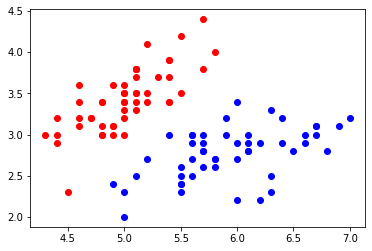

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
# 测试数据
iris = datasets.load_iris()
X = iris.data
y = iris.target
X = X[y<2,:2]
y = y[y<2]
plt.scatter(X[y==0,0], X[y==0,1], color="red")
plt.scatter(X[y==1,0], X[y==1,1], color="blue")
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

0.96

In [5]:
log_reg.predict_proba(X_test)

array([0.98571554, 0.02603215, 0.84966489, 0.01442144, 0.99577837,
       0.69599006, 0.14301485, 0.03810868, 0.00244301, 0.02847909,
       0.06189945, 0.07519726, 0.97897119, 0.01729645, 0.49818865,
       0.86676755, 0.17057013, 0.5562134 , 0.91168961, 0.85573665,
       0.04654915, 0.01285557, 0.97308329, 0.89564404, 0.00850298])

## 决策边界(Decision-Boundary)

### 二分类决策边界

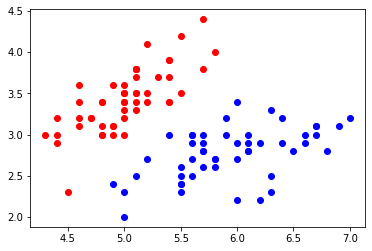

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
#载入数据
iris = datasets.load_iris()
X = iris.data
y = iris.target
X = X[y<2,:2]
y = y[y<2]
plt.scatter(X[y==0,0], X[y==0,1], color="red")
plt.scatter(X[y==1,0], X[y==1,1], color="blue")
plt.show()

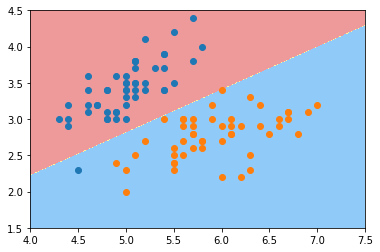

In [7]:
# 画决策边界
def plot_decision_boundary(model, axis):
    
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1]-axis[0])*100)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3]-axis[2])*100)).reshape(-1, 1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]

    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A','#FFF59D','#90CAF9'])
    
    plt.contourf(x0, x1, zz, cmap=custom_cmap)
    
plot_decision_boundary(log_reg, axis=[4, 7.5, 1.5, 4.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

### KNN决策边界

0.88


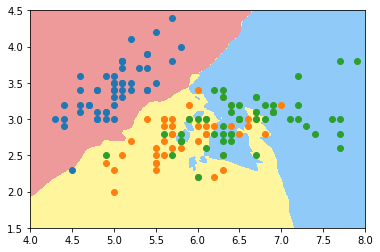

In [8]:
from sklearn.neighbors import KNeighborsClassifier
# 过拟合的决策边界
knn_clf_all = KNeighborsClassifier()
knn_clf_all.fit(iris.data[:,:2], iris.target)
print(knn_clf_all.score(X_test, y_test))
plot_decision_boundary(knn_clf_all, axis=[4, 8, 1.5, 4.5])
plt.scatter(iris.data[iris.target==0,0], iris.data[iris.target==0,1])
plt.scatter(iris.data[iris.target==1,0], iris.data[iris.target==1,1])
plt.scatter(iris.data[iris.target==2,0], iris.data[iris.target==2,1])
plt.show()

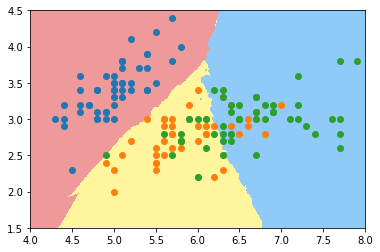

In [9]:
# 减少过拟合,通过增加超参数k
knn_clf_all = KNeighborsClassifier(n_neighbors=50)
knn_clf_all.fit(iris.data[:,:2], iris.target)

plot_decision_boundary(knn_clf_all, axis=[4, 8, 1.5, 4.5])
plt.scatter(iris.data[iris.target==0,0], iris.data[iris.target==0,1])
plt.scatter(iris.data[iris.target==1,0], iris.data[iris.target==1,1])
plt.scatter(iris.data[iris.target==2,0], iris.data[iris.target==2,1])
plt.show()

## 添加多项式特征

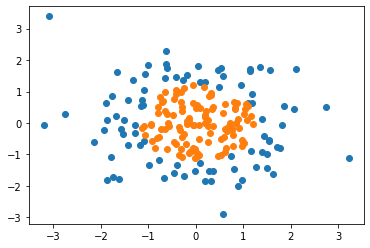

In [10]:
# 圆形边界数据
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(666)
X = np.random.normal(0, 1, size=(200, 2))
y = np.array((X[:,0]**2+X[:,1]**2)<1.5, dtype='int')
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

### 使用线性回归特征

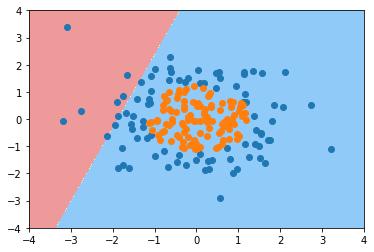

In [12]:
# 简单线性回归的决策边界
log_reg = LogisticRegression()
log_reg.fit(X, y)
#画决策边界
def plot_decision_boundary(model, axis):
    
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1]-axis[0])*100)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3]-axis[2])*100)).reshape(-1, 1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]

    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A','#FFF59D','#90CAF9'])
    
    plt.contourf(x0, x1, zz, cmap=custom_cmap)
plot_decision_boundary(log_reg, axis=[-4, 4, -4, 4])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

### 使用多项式特征

0.95


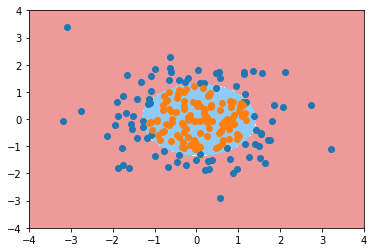

In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def PolynomialLogisticRegression(degree):
    return Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('std_scaler', StandardScaler()),
        ('log_reg', LogisticRegression())
    ])

poly_log_reg = PolynomialLogisticRegression(degree=2)
poly_log_reg.fit(X, y)

print(poly_log_reg.score(X, y))

plot_decision_boundary(poly_log_reg, axis=[-4, 4, -4, 4])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

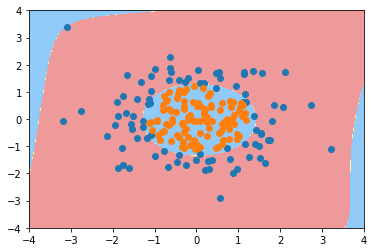

In [14]:
# 过拟合情况 degree = 20
poly_log_reg2 = PolynomialLogisticRegression(degree=20)
poly_log_reg2.fit(X, y)

plot_decision_boundary(poly_log_reg2, axis=[-4, 4, -4, 4])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

## sklean实现

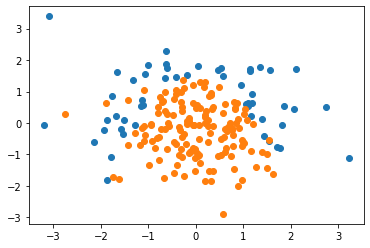

In [0]:
# 声称有噪点的数据
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(666)
X = np.random.normal(0, 1, size=(200, 2))
y = np.array((X[:,0]**2+X[:,1])<1.5, dtype='int')
for _ in range(20):
    y[np.random.randint(200)] = 1

plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

### 二分类逻辑回归

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
print(log_reg.score(X_train, y_train))
print(log_reg.score(X_test, y_test))

0.66
0.72


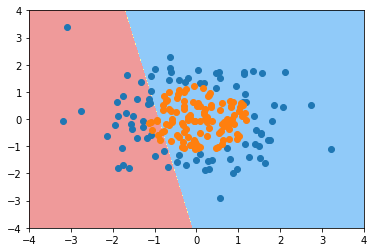

In [16]:
# 线性逻辑回归
plot_decision_boundary(log_reg, axis=[-4, 4, -4, 4])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

In [17]:
# 多项式逻辑回归
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def PolynomialLogisticRegression(degree):
    return Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('std_scaler', StandardScaler()),
        ('log_reg', LogisticRegression())
    ])
poly_log_reg = PolynomialLogisticRegression(degree=2)
poly_log_reg.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('std_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [18]:
print(poly_log_reg.score(X_train, y_train))
print(poly_log_reg.score(X_test, y_test))

0.9733333333333334
0.96


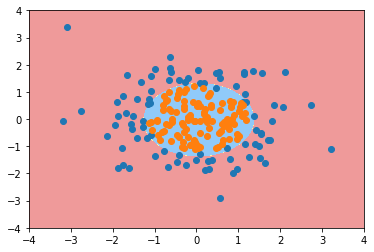

In [19]:
plot_decision_boundary(poly_log_reg, axis=[-4, 4, -4, 4])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

In [20]:
# 添加正则,C代表sigmod函数前的参数,越小正则越强,(sklearn不适用梯度下降求出来的)
def PolynomialLogisticRegression(degree,C,penalty='l2',solver="lbfgs"):
    return Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('std_scaler', StandardScaler()),
        ('log_reg', LogisticRegression(C=C,penalty=penalty,solver=solver))
    ])

poly_log_reg3 = PolynomialLogisticRegression(degree=20, C=0.1,penalty='l1',solver="liblinear")
poly_log_reg3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=20, include_bias=True,
                                    interaction_only=False, order='C')),
                ('std_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('log_reg',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [21]:
print(poly_log_reg3.score(X_train, y_train))
print(poly_log_reg3.score(X_test, y_test))

0.9
0.92


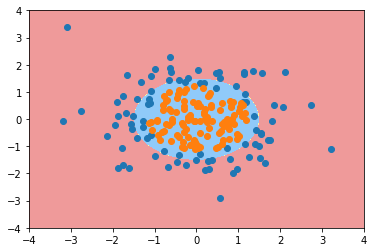

In [22]:
plot_decision_boundary(poly_log_reg3, axis=[-4, 4, -4, 4])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

### 多分类逻辑回归

In [26]:
# multi_class= 控制ovo和ovr
# 使用ovr
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

iris = datasets.load_iris()
X = iris.data[:,:2]
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)
log_reg = LogisticRegression(multi_class='ovr')
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

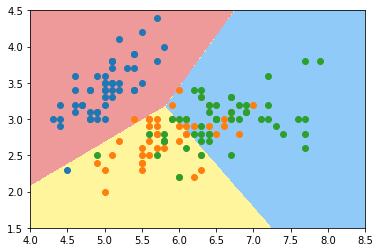

In [27]:
plot_decision_boundary(log_reg, axis=[4, 8.5, 1.5, 4.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.scatter(X[y==2,0], X[y==2,1])
plt.show()

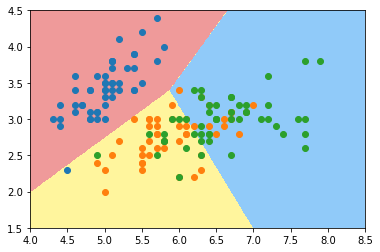

In [28]:
# 使用ovo
log_reg = LogisticRegression(multi_class='multinomial')
log_reg.fit(X_train, y_train)
plot_decision_boundary(log_reg, axis=[4, 8.5, 1.5, 4.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.scatter(X[y==2,0], X[y==2,1])
plt.show()